In [1]:
from src.imports import Path,torch
from src import datasets
from src import utils
from src import labeller
from src import train
from src import loss_func
from src import metrics
from src import models
from src import test
from src import modelutils
import pandas as pd
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [2]:
#getting the paths to the datasets
path_dogs = Path('input/dogImages/')
path_human = Path('input/lfw')

In [3]:
#creating splits for the human_face_dataset
human_train, human_valid, human_test = utils.create_splits_human_dataset(path_human)

We have the following split for human face dataset

In [4]:
def get_human_files(folders):
    files = []
    [files.extend(utils._get_files(folder)) for folder in folders]
    return files

In [5]:
train_set = get_human_files(human_train)
valid_set = get_human_files(human_valid)
test_set = get_human_files(human_test)
total_files = len(get_human_files(utils.get_dirs(path_human)))
print(f"Images in train set: {len(train_set)}")
print(f"Images in valid set: {len(valid_set)}")
print(f"Images in test set: {len(test_set)}")
print(f"split % in train set: {len(train_set)/total_files * 100}")
print(f"split % in valid set: {len(valid_set)/total_files * 100}")
print(f"split % in test set: {len(test_set)/total_files * 100}")

Images in train set: 8926
Images in valid set: 2014
Images in test set: 2293
split % in train set: 67.45258066953828
split % in valid set: 15.219526940225196
split % in test set: 17.327892390236528


In [6]:
#splits for dog images
dog_train= utils.get_files(path_dogs/'train')
dog_valid= utils.get_files(path_dogs/'valid')
dog_test= utils.get_files(path_dogs/'test')

In [7]:
total_dog = len(dog_train) + len(dog_valid) + len(dog_test)
print(f"Images in train set: {len(dog_train)}")
print(f"Images in valid set: {len(dog_valid)}")
print(f"Images in test set: {len(dog_test)}")
print(f"split % in train set: {len(dog_train)/total_dog * 100}")
print(f"split % in valid set: {len(dog_valid)/total_dog * 100}")
print(f"split % in test set: {len(dog_test)/total_dog * 100}")

Images in train set: 6680
Images in valid set: 835
Images in test set: 836
split % in train set: 79.99042030894503
split % in valid set: 9.99880253861813
split % in test set: 10.010777152436834


In [8]:
def plot_breed_distribution(split):
    plt.figure()
    df = pd.DataFrame({"dog_images":split})
    df['breed_names'] = df.dog_images.map(lambda x: str(x).split('/')[-2])
    df['breed_names'].value_counts().plot(kind='bar')
    plt.xlabel('breeds')
    plt.tick_params(axis='x',    
               which='both',      
               bottom=False,      
               top=False,         
               labelbottom=False)
    plt.show()

Train Distribution


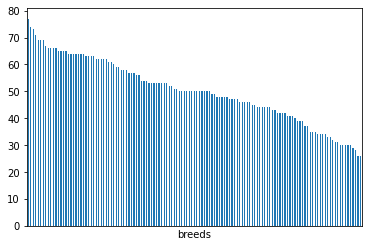

In [9]:
print('Train Distribution')
plot_breed_distribution(dog_train)

Test Distribution


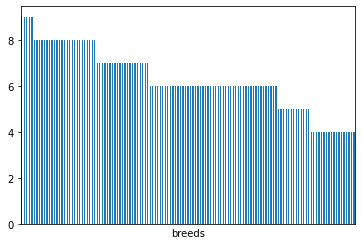

In [10]:
print('Test Distribution')
plot_breed_distribution(dog_valid)

Test Distribution


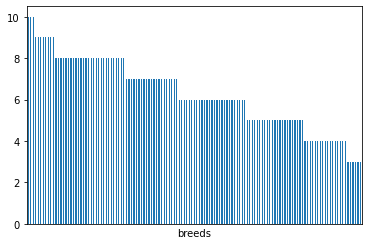

In [11]:
print('Test Distribution')
plot_breed_distribution(dog_test)

We can see that the dataset is not perfectly balanced. But there is not need to worry about the imbalance in this dataset for now the imbalance is not significant 

# Benchmark Model

Getting the Batch mean and std for normalizing images

In [12]:
TRAIN_BATCH_SIZE = 256

In [13]:
train_ds, valid_ds = train.get_datasets(path_dogs, human_train, human_valid, 
                                       dog_human_label_func=labeller.human_or_dog, breed_label_func=labeller.get_breed_label)

dls = train.get_dls(train_ds, valid_ds, TRAIN_BATCH_SIZE)
batch_stat = utils.get_batch_stat(train_ds)

In [14]:
# Creating the train and Valid datasets
train_ds, valid_ds = train.get_datasets(path_dogs, human_train, human_valid, stats=batch_stat,
                                       dog_human_label_func=labeller.human_or_dog, breed_label_func=labeller.get_breed_label)
# Creating the dataloaders
dls = train.get_dls(train_ds,valid_ds, 256)

We can have a look at the data with the augmentations applied now

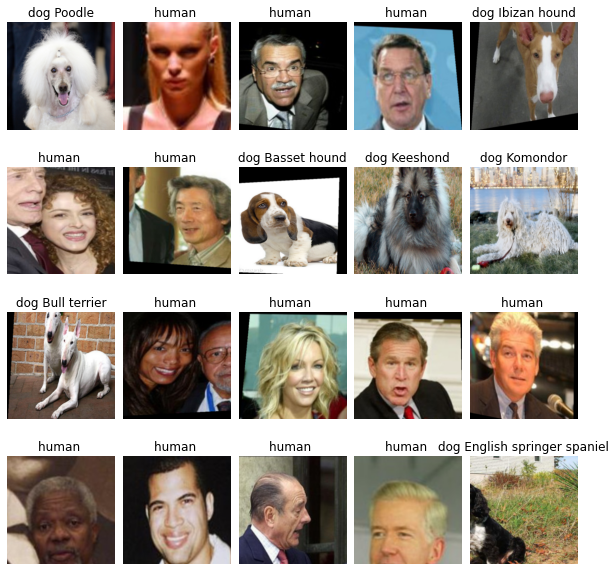

In [15]:
utils.show_batch(dls[0],rows=4,cols=5, **batch_stat)

I have created the model in the supporting files in the src folder. I will just print the model architecture here. All the files for the models and the other Modules are in `src/models` and `src/modelutils`

```
class ModelScratch(nn.Module):
    """
    Model Scratch is a custom architecture for dog vs human classification
    along with dog breed classification. The architecture has 135
    activations as outputs; 133 for dog breeds and 2 for human vs dog each.
    """

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
                      conv_layer(3, 16, ks=3, s=2, p=1),  # 112
                      nn.Dropout2d(p=0.05),
                      DenseBlock(16, 8),
                      nn.Dropout2d(p=0.05),
                      conv_layer(24, 64, ks=3, s=2, p=1),  # 56
                      nn.Dropout2d(p=0.05),
                      DenseBlock(64, 64),
                      nn.Dropout2d(p=0.05),
                      conv_layer(128, 256, ks=3, s=2, p=1),  # 28
                      nn.Dropout2d(p=0.05),
                      ResBlock(256),
                      nn.Dropout2d(p=0.05),
                      conv_layer(256, 512, ks=3, s=2, p=1),  # 14
                      AdaptivePooling(1),
                      Lambda(flatten),
                      nn.Linear(512, 300),
                      nn.BatchNorm1d(300),
                      nn.ReLU(),
                      nn.Dropout(p=0.05),
                      nn.Linear(300, 135),
                      nn.BatchNorm1d(135)
        )

    def forward(self, x):
        return self.layers(x)

```

In [16]:
# getting the model
model = models.ModelScratch()
device = train.get_device()
model.to(device)
# optimizer for training the model
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-2)
# loss function for training model from scratch
criterion = loss_func.CustomLoss(train_ds.dog_human_labeller)

In [17]:
# recorder will track the metrics and loss for each epoch
recorder = metrics.Recorder()

In [18]:
# !pip install torch-summary
import torchsummary
torchsummary.summary(model,(3,224,224),verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 135]                 --
|    └─Sequential: 2-1                   [-1, 16, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 16, 112, 112]        432
|    |    └─BatchNorm2d: 3-2             [-1, 16, 112, 112]        32
|    |    └─ReLU: 3-3                    [-1, 16, 112, 112]        --
|    └─Dropout2d: 2-2                    [-1, 16, 112, 112]        --
|    └─DenseBlock: 2-3                   [-1, 24, 112, 112]        --
|    |    └─Sequential: 3-4              [-1, 8, 112, 112]         1,168
|    |    └─Sequential: 3-5              [-1, 8, 112, 112]         592
|    └─Dropout2d: 2-4                    [-1, 24, 112, 112]        --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-6                  [-1, 64, 56, 56]          13,824
|    |    └─BatchNorm2d: 3-7             [-1, 64, 56, 56]          128
|    

## Training the Benchmark model

In [19]:
train.run(20, model, optimizer,criterion, dls, device, recorder,max_lr=0.1)


-----  --------  --------  --------  --------  --------  --------
Epoch  T_loss    v_loss    va_human  va_dog    ta_breed  va_breed
1      5.938559  5.777413  0.878905  0.718147  0.010180  0.016766
2      5.476068  6.213561  0.648649  0.898210  0.021856  0.016766
3      5.070798  4.997719  0.935416  0.862057  0.031737  0.028743
4      4.809140  5.276048  0.873640  0.952264  0.039222  0.034731
5      4.561700  7.127635  0.677431  0.813619  0.055838  0.040719
6      4.392706  5.440241  0.782380  0.902422  0.066766  0.064671
7      4.165183  5.827712  0.851878  0.945244  0.083383  0.039521
8      4.026721  4.582003  0.979993  0.947701  0.096856  0.070659
9      3.813455  7.902262  0.542998  0.713935  0.124850  0.070659
10     3.664855  4.017626  0.982099  0.952615  0.140868  0.136527
11     3.522182  3.703928  0.987715  0.975079  0.169461  0.141317
12     3.275004  3.782756  0.982450  0.987013  0.209132  0.160479
13     3.088906  3.439025  0.987013  0.990874  0.235928  0.201198
14     2.

## Testing the Benchmark model

In [20]:
# creating the test dataset
test_ds = datasets.Dataset(path_dogs, human_test, 'test',train_ds.breed_labeller,train_ds.dog_human_labeller, stats=batch_stat)

In [21]:
# The test function takes a model and test_ds and creates a dataloader
# and runs the evaluation loop. 
# It prints and return a tuple of all the metrics recorded
out = test.test(model, test_ds, criterion, device)

100%|██████████| 49/49 [00:04<00:00, 11.21it/s]

------------------  ------------------  ------------------  -------------------
Test_loss           test_acc_human      test_acc_dog        test_acc_breed
0.7778232097625732  0.9939277768135071  0.9958453178405762  0.35885167121887207
------------------  ------------------  ------------------  -------------------


In [22]:
def plot_train_loss(recorder):
    plt.plot(recorder.train_loss,label='train-loss')
    plt.plot(recorder.valid_loss,label='valid-loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Plot of loss')
    plt.legend()
    plt.show()

In [23]:
def plot_train_breed_acc(recorder):
    plt.plot(recorder.train_acc_breed,label='train-acc')
    plt.plot(recorder.valid_acc_breed,label='valid-acc')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.title('Plot of Breed Accuracy')
    plt.legend()
    plt.show()

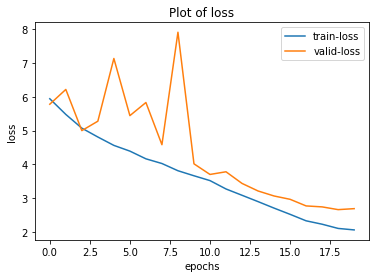

In [24]:
plot_train_loss(recorder)

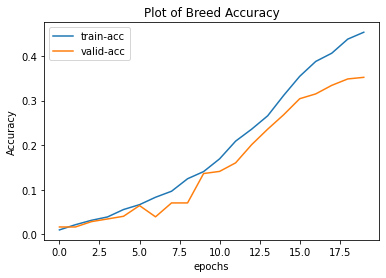

In [25]:
plot_train_breed_acc(recorder)

In [29]:
utils.save_model(model,  f'model_scratch_{recorder.valid_acc_breed[-1]:.2f}', 
                 train_ds.breed_labeller, train_ds.dog_human_labeller,
                 batch_stat)

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  

In [33]:
print(f"accuracy for dog detection(Train): {recorder.train_acc_dog[-1]:.4f}")
print(f"accuracy for dog detection(Valid): {recorder.valid_acc_dog[-1]:.4f}")

accuracy for dog detection(Train): 0.9876
accuracy for dog detection(Valid): 0.9940


__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  

In [35]:
print(f"accuracy for human face detection(Train): {recorder.train_acc_human[-1]:.4f}")
print(f"accuracy for human face detection(Valid): {recorder.valid_acc_human[-1]:.4f}")

accuracy for human face detection(Train): 0.9958
accuracy for human face detection(Valid): 0.9954


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


__Answer__:
I resize the images using torchvision transforms Resize. The image is first resized to a 560x560 i.e. 2.5 times the final image size image and then a RandomPerspective transform is applied with a distortion of 0.3 and a probability of 0.5. Then a RandomResizedCrop is applied followed by a RandomHorizontalFlip with a probability of 0.5. In the end, the images are normalized.
I am using a 224X224 input for the input. It gives good accuracy and generalizes well to other images.

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

To create the CNN architecture, I used the following approach.
1. The input size in 3x224x224. I started adding Convolutional layers followed by BatchNorm and ReLU. 
2. Each Conv layer is followed by BatchNorm and ReLU. All filters I used were of size 3x3. As a 3x3 filter can have the same effective receptive field as 5x5 or 7x7 when stacked. 
3. I made a simple ResBlock and DenseBlock and used those for feature extraction. 
4. While downsampling, I used a single Conv2d layer with a stride of 2 and padding 1 as stated above.
5. After every conv layer, ResBlock and DenseBlock, I have added a Dropout2d for regularization.

So my effective architecture approach was :

DownSample -> Feature Extractor -> Down Sample -> Feature Extractor .. -> AdaptivePooling(A combination of maxpool and avgpool) -> Flatten -> Linear -> BatchNorm -> ReLU -> Linear -> BatchNorm

The model activations shape during forward pass would be as shown below:
1. batchsize, 16, 112, 112 after first conv
2. batchsize, 24, 112, 112 after the first Dense Block as denseblock concatenate the input to its activations.
3. batchsize, 64,  56, 56  after the 2nd conv
4. batchsize, 128, 56, 56  after the 2nd Dense block
5. batchsize, 256, 28, 28  after the 3rd conv
6. batchsize, 256, 28, 28  after the ResBlock 
7. batchsize, 512, 14, 14  after the final conv
8. batchsize, 512,  1,  1  after the AdaptivePooling
9. batchsize, 512 after flattening
10.batchsize, 300 after Linear Layer
11.batchsize, 135 output

## Final CNN Model with transfer learning

In [13]:
# Imagenet stats will be used as the model is pretrained on ImageNet
imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
# Creating the train and Valid datasets
train_ds, valid_ds = train.get_datasets(path_dogs, human_train, human_valid, stats=imagenet_stats,
                                       dog_human_label_func=labeller.human_or_dog, breed_label_func=labeller.get_breed_label)
# Creating the dataloaders
dls = train.get_dls(train_ds,valid_ds, 256)

```
class ModelTransfer(nn.Module):
    """
    Model Transfer is a resnet34 pretrained on Imagenet with a custom
    head for our specific data
    """
    def __init__(self, pretrained=True):
        super().__init__()
        self.model = models.resnet34(pretrained=pretrained)
        self.model.fc = nn.Linear(512, 300)
        self.head = nn.Sequential(nn.BatchNorm1d(300),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(300, 135),
                                  nn.BatchNorm1d(135))

    def forward(self, x):
        x = self.head(self.model(x))
        return x
```        

In [89]:
import torchsummary
torchsummary.summary(model_transfer, (3,224,224),verbose=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 300]                 --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 64, 56, 56]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 56, 56]          (73,984)
|    |    └─BasicBlock: 3-2              [-1, 64, 56, 56]          (73,984)
|    |    └─BasicBlock: 3-3              [-1, 64, 56, 56]          (73,984)
|    └─Sequential: 2-6                   [-1, 128, 28, 28]         --
|    |    └─BasicBlock: 3-4              [-1, 128, 28, 28]         (230,144)
|    |    └─BasicBlock: 3-5              [-1, 128, 28, 28]         (295,424)
|    |    └─BasicBlock: 3-6              [-1, 1

In [14]:
# getting the model
model_transfer = models.ModelTransfer()
device = train.get_device()
model_transfer.to(device)
# optimizer for training the model
optimizer = torch.optim.Adam(model_transfer.parameters(), lr = 1e-3)
# loss function for training model from scratch
criterion = loss_func.CustomLoss(train_ds.dog_human_labeller)

In [18]:
recorder = metrics.Recorder()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

Transfer learning is a technique in Deep learning which refers to using a model trained for some task for a completedly different task. The task we have at hand is breed classification and dog and human detection. I will be using a Resnet34 pretrained on ImageNet Dataset with 1.3 Million images for transfer learning. So rather than starting from scratch we already have a model that is exceptionally good at one thing. 

This pretrained architecture has learned lots of features regarding images in general and is a very good feature extractor. Only the final layers of the model are specific to the ImageNet Classfication task. So I will replace the final classifier with a custom head for our task at hand, which is dog and human detection and breed classification. 

We can see that the final layer of the resnet34 has 512 input features and 1000 output features. We will replace this final layer with our custom layer.
First I replaced the fc layer of resnet34 with a Linear Layer with 512 input features and 300 output features followed by BatchNorm and ReLU. Then a Dropout with p 0.2

## Training the Final Model using Transfer Learning

In [19]:
# freezing the pretrained part as stated above
modelutils.freeze(model_transfer.model)

In [20]:
train.run(10, model_transfer,optimizer,criterion, dls, device, recorder,max_lr=1e-3)


-----  --------  --------  --------  --------  --------  --------
Epoch  T_loss    v_loss    va_human  va_dog    ta_breed  va_breed
1      2.442593  2.321616  0.998245  0.784135  0.582335  0.514970
2      1.714864  3.667790  0.641278  0.989119  0.598204  0.379641
3      1.522152  4.386450  0.552475  0.901018  0.590868  0.380838
4      1.259984  1.771893  0.996139  0.997894  0.646108  0.552096
5      1.048562  1.194862  0.995788  0.993682  0.686976  0.669461
6      0.839401  0.923419  0.997894  0.996490  0.741916  0.718563
7      0.672969  0.705247  0.998596  0.999649  0.795060  0.777246
8      0.529828  0.625141  0.999649  0.999649  0.837725  0.819162
9      0.430559  0.554000  1.000000  1.000000  0.867665  0.816766
10     0.381231  0.550313  1.000000  1.000000  0.880689  0.832335
-----  --------  --------  --------  --------  --------  --------


## Testing the final model

In [21]:
# creating the test dataset
test_ds = datasets.Dataset(path_dogs, human_test, 'test',train_ds.breed_labeller,train_ds.dog_human_labeller, stats=imagenet_stats)

In [23]:
# The test function takes a model and test_ds and creates a dataloader
# and runs the evaluation loop. 
# It prints and return a tuple of all the metrics recorded
out = test.test(model_transfer, test_ds, criterion, device)

100%|██████████| 49/49 [00:06<00:00,  7.98it/s]

-----------------  ------------------  ------------------  ------------------
Test_loss          test_acc_human      test_acc_dog        test_acc_breed
0.155547633767128  0.9996803998947144  0.9996803998947144  0.8540669679641724
-----------------  ------------------  ------------------  ------------------


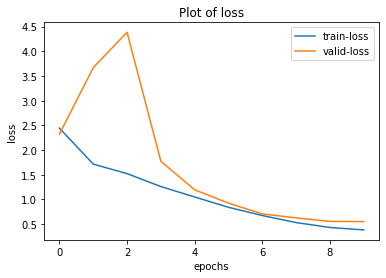

In [25]:
plot_train_loss(recorder)

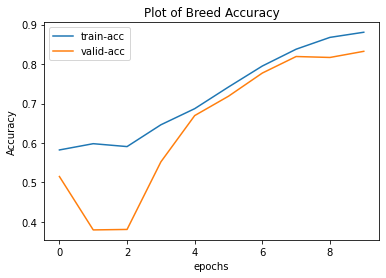

In [28]:
plot_train_breed_acc(recorder)

In [33]:
utils.save_model(model_transfer,  f'model_transfer_{recorder.valid_acc_breed[-1]:.2f}', 
                 train_ds.breed_labeller, train_ds.dog_human_labeller,
                 imagenet_stats)

# Getting the predictions

In [64]:
saved_dict = torch.load('model_transfer_0.83',map_location='cpu')

In [68]:
model = models.ModelTransfer(pretrained=False)
model.load_state_dict(saved_dict['model'])
model.eval()

dog_human_labeller = saved_dict['dog_human_labeller']
breed_labeller = saved_dict['breed_labeller']
dog_idx = dog_human_labeller.label_dict['dog']
human_idx = dog_human_labeller.label_dict['human']
dog_thresh = 0.9
human_thresh = 0.5

In [76]:
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision import transforms

def get_tfms(stats):
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(**stats)
    ])


def predict(img_path):
    """
    Takes image path as input and returns the predictions.
    """
    img = Image.open(img_path).convert('RGB')
    tfms = get_tfms(imagenet_stats)
    img_tensor = tfms(img)
    img_tensor = img_tensor[None, ...]
    model_transfer.to(device)
    img_tensor = img_tensor.to(device)
    preds = torch.sigmoid(model_transfer(img_tensor))
    dog_score = preds[:, dog_idx]
    human_score = preds[:, human_idx]
    breed = torch.argmax(preds[:, 2:])
    breed_class = breed_labeller.label_lookup[breed.item()]
    is_dog = True if dog_score > dog_thresh else False
    is_human = True if human_score > human_thresh else False
    out1 = 'dog' if is_dog else None
    out1 = 'human' if is_human else out1
    return out1, breed_class, img

In [78]:
%%time
predict(dog_train[0])[:2]

CPU times: user 41.1 ms, sys: 75 ms, total: 116 ms
Wall time: 21.4 ms


('dog', 'Affenpinscher')

In [79]:
%%time
predict(train_set[0])[:2]

CPU times: user 28.7 ms, sys: 72.8 ms, total: 101 ms
Wall time: 15.3 ms


('human', 'Great dane')

## Final Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

In [83]:
def run_app(img_path):
    pred = predict(img_path)
    if pred[0] == 'human':
        print(f'Hi human, You look like a {pred[1]}')
    elif pred[0] == 'dog':
        print(f'Hi Dog. The predicted breed is {pred[1]}')
    else:
        print('Object not recognized. We don\t support this object.')
        return
    plt.imshow(pred[2])
    plt.axis('off')
    plt.show()
        

Hi human, You look like a Cane corso


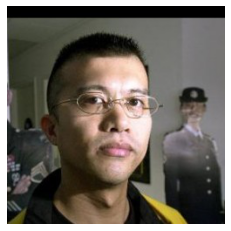

In [84]:
run_app(test_set[0])

Hi Dog. The predicted breed is Affenpinscher


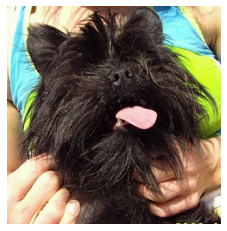

In [85]:
run_app(dog_test[0])

# Testing the app

Lets try a cat image

Hi Dog. The predicted breed is Boston terrier


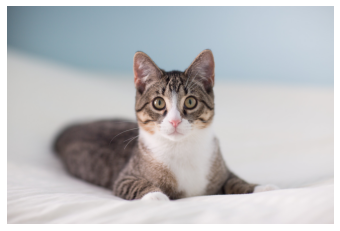

In [86]:
run_app('./cat.jpg')

Its definitely not a Boston Terrier but a boston terrier looks somewhat similar.

Hi Dog. The predicted breed is Mastiff


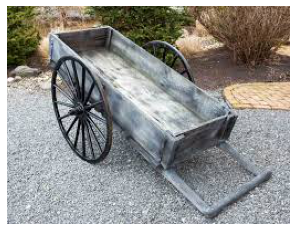

In [87]:
run_app('./cart.jfif')

Thats bad

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

1. Collect more data as the dataset is not very huge. The provided dataset has enough to test our  hypothesis that the model will learn. 
2. Mixup and label smoothing can be used to further improve the accuracy of the models. 
3. Using different architecture.
4. There are more transfer learning techniques that can be implemented: 
    1. Gradual Unfreezing
    2. Using differential learning rates for the different parts of the model.